# Data queries - Highlighted snippets and aggregations

When running search queries on large collections, you may be interested in retrieving only
certain details of the query matches, instead of downloading the full documents in the result set.
For instance, you may want to retrieve snippets from some fields where the matches occur or 
you may be interested in just aggregated values from the matched documents. In this example,
we show several search capabilities supported by Deep Search to make some data anaytics
use cases more efficient.

### Access required

The content of this notebook requires access to Deep Search capabilities which are not
available on the public access system.

[Contact us](https://ds4sd.github.io) if you are interested in exploring
these Deep Search capabilities.

### Set notebooks parameters

In [1]:
from dsnotebooks.settings import NotebookSettings

# notebook settings auto-loaded from .env / env vars
notebook_settings = NotebookSettings()

PROFILE_NAME = notebook_settings.profile  # the profile to use

### Import example dependencies

In [2]:
# Import standard dependencies
import pandas as pd
from numerize.numerize import numerize
from tqdm import tqdm

# Import the deepsearch-toolkit
import deepsearch as ds
from deepsearch.cps.client.components.elastic import ElasticDataCollectionSource
from deepsearch.cps.queries import DataQuery

### Connect to Deep Search

In [3]:
api = ds.CpsApi.from_env(profile_name=PROFILE_NAME)

---

## Get highlighted snippets

In this section we will run some queries and get highlighted snippets from the matches, using documents from the Climate & Sustainability domain.

- [List data collections from the Climate & Sustainability domain](#List-data-collections-from-the-Climate-&-Sustainability-domain)
- [Search IPCC reports on climate change mitigation](#Search-IPCC-reports-on-climate-change-mitigation)
- [Get snippets from matched documents](#Get-snippets-from-matched-documents)
- [Configure the highlightning options](#Configure-the-highlightning-options)

### List data collections from the _Climate & Sustainability_ domain

The Deep Search platform offers access to collections from several domains, like _Climate & Sustainability_. We will list these collections, which may be of type _Document_ (text reports, mainly unstructured) or _Record_ (databases). In particular, we will focus on IPCC reports, published by [The Intergovernmental Panel on Climate Change (IPCC)](https://www.ipcc.ch), the United Nations body for assessing the science related to climate change.

In [4]:
# Fetch list of all data collections
collections = api.elastic.list(domain="Climate & Sustainability")
collections.sort(key=lambda c: c.name.lower())

In [5]:
# Visualize summary table
results = [
    {
        "Name": c.name,
        "Type": c.metadata.type,
        "Num entries": numerize(c.documents),
        "Date": c.metadata.created.strftime("%Y-%m-%d"),
        "Coords": f"{c.source.elastic_id}/{c.source.index_key}",
    }
    for c in collections
]
display(pd.DataFrame(results))

,Name,Type,Num entries,Date,Coords
0,IPCC,Document,819,2023-06-15,default/ipcc


### Search IPCC reports on climate change mitigation

As a first example, we search for IPCC reports that may address the topic of climate change mitigation, using a keyword search query. Since we are only interested in identifying those reports, we request a short list of metadata fields from the matched reports and we can thus avoid unnecessary data transfers.
The results are displayed on a table with the columns title, publication year, and number of pages.

In [6]:
# Run a proximity query using some keywords with maximum edit distance 5
search_query = "\"climate change mitigation\"~5"

data_collection = ElasticDataCollectionSource(elastic_id="default", index_key="ipcc")
page_size = 50

# Prepare the data query
query = DataQuery(
    search_query, # The search query to be executed
    source=["description.title", "description.publication_date", "file-info.#-pages"], # Fields to fetch
    limit=page_size, # The size of each request page
    coordinates=data_collection # The data collection to be queried
)

# Iterate through all results by fetching `page_size` results at the same time
all_results = []
cursor = api.queries.run_paginated_query(query)
for result_page in tqdm(cursor):
    all_results.extend(result_page.outputs["data_outputs"])

print(f"Finished fetching all data. Total is {len(all_results)} records.")

0it [00:00, ?it/s]

11it [00:14,  1.29s/it]

Finished fetching all data. Total is 422 records.


In [7]:
# Visualize summary table
df = pd.json_normalize(all_results).loc[
    :,["_source.description.title", "_source.description.publication_date", "_source.file-info.#-pages"]]
df.columns = ["Title", "Publication Date", "Number of Pages"]
df["Publication Year"] = df["Publication Date"].str[:4]

df.loc[:,["Title", "Publication Year", "Number of Pages"]].head(10).style.set_properties(
    subset=["Title"], **{"text-align": "left"}).set_table_styles([dict(selector="th", props=[("text-align", "left")])])

,Title,Publication Year,Number of Pages
0,"AR4 Climate Change 2007: Impacts, Adaptation, and Vulnerability (ar4-wg2-chapter20-1)",2007,32
1,AR4 Climate Change 2007: Mitigation of Climate Change (ar4_wg3_errata_spmts_en),2007,1
2,AR5 Synthesis Report: Climate Change 2014 (AR5_SYR_Glossary_ru),2014,18
3,AR4 Climate Change 2007: Mitigation of Climate Change (ar4-wg3-chapter1-1),2007,22
4,AR5 Climate Change 2014: Mitigation of Climate Change (ipcc_wg3_ar5_annex-ii),2014,48
5,"TAR Climate Change 2001: Impacts, Adaptation, and Vulnerability (wg2TARchap13)",2001,52
6,AR6 Climate Change 2022: Mitigation of Climate Change (IPCC_AR6_WGIII_Chapter04_SM),2022,8
7,AR5 Climate Change 2014: Mitigation of Climate Change (WGIIIAR5_SPM_TS_Volume_ru-1),2014,188
8,AR5 Climate Change 2013: The Physical Science Basis (WG1AR5_FactSheet),2013,2
9,AR4 Climate Change 2007: Mitigation of Climate Change (ar4-wg3-chapter4-1),2007,72


### Get snippets from matched documents

If we are doing an exploratory analysis, we may not want to fetch the entire report for each of the matches. We could be interested in identifying the context in the document that created the match. For this purpose, we can request Deep Search to return highlighted snippets.
Let's narrow down the scope and look for any text in IPCC reports addressing the topic of carbon sequestration to mitigate climate change.

In [8]:
# Prepare the data query
search_query = "\"climate change carbon sequestration\"~10"

highlight = {"fields": {"*": {}}}

query = DataQuery(
    search_query,
    source=["file-info.filename"], # Fetch only the report file name
    limit=page_size, # Fetch maximum `page_size` reports
    highlight=highlight,
    coordinates=data_collection
)

all_results = []
result = api.queries.run(query)
all_results = result.outputs["data_outputs"]

print(f"Finished fetching all data. Total is {len(all_results)} records.")

Finished fetching all data. Total is 45 records.


In [9]:
# Format and visualize the first 10 snippets
def format_highlight_results(ds_results):
    results_table = []
    
    for row in all_results:
        for field in row.get("highlight", {}).keys():
            for snippet in row["highlight"][field]:
                result = {
                    "Report": row["_source"]["file-info"]["filename"],
                    "Field": field,
                    "Snippet": snippet
                }
                results_table.append(result)
                
    return pd.DataFrame(results_table)

df = format_highlight_results(all_results)
df_style = df.head(10).style.set_table_styles([dict(selector="th", props=[("text-align", "left")])])
df_style.set_properties(**{"text-align": "left"})

,Report,Field,Snippet
0,WGIIAR5-Chap24_OLSM.pdf,main-text.text,"He, 2006: Climate change impacts on agriculture and soil carbon sequestration potential in the Huang-Hai"
1,IPCC_AR6_WGII_Chapter14.pdf,main-text.text,"., 2017: Agroforestry: a sustainable environmental practice for carbon sequestration under the climate"
2,IPCC_AR6_WGII_Chapter14.pdf,main-text.text,change scenarios-a review.
3,The-Regional-Impact.pdf,main-text.text,"A ccording to Batjes and Sombroek (1997), however, the effect of climate change on carbon sequestration"
4,Chapter-2-Bioenergy-1.pdf,main-text.text,Temporary carbon sequestration cannot prevent climate change.
5,Chapter-2-Bioenergy-1.pdf,main-text.text,Soil carbon sequestration impacts on global climate change and food security.
6,Chapter-2-Bioenergy-1.pdf,main-text.text,Quantifying the effectiveness of climate change mitigation through forest plantations and carbon sequestration
7,IPCC_AR6_WGII_CCP2.pdf,main-text.text,"., 2020b), climate change mitigation (through carbon sequestration; Macreadie et al., 2017; Rovai et"
8,IPCC_AR6_WGII_CCP2.pdf,main-text.text,"., 2020: Carbon sequestration and storage in Norwegian Arctic coastal wetlands: impacts of climate change"
9,IPCC_AR6_WGIII_Chapter_06.pdf,tables.data.text,"Lee, 2016: Optimal bioenergy power generation for climate change mitigation with or without carbon"


### Configure the highlightning options

By passing options to the `DataQuery` object, we can configure the highlighted snippets for different analytics scenarios and to improve the presentations of results. You can find more details in [Elasticsearch Highlightning]( https://www.elastic.co/guide/en/elasticsearch/reference/7.11/highlighting.html) documentation.

#### Set the highlighted fields and fragments

We can fetch snippets from given fields only, like paragraphs. You need to specifify the full path of the text field.

In [10]:
highlight["fields"] = {"main-text.text": {}}
query = DataQuery(
    search_query, source=["file-info.filename"], limit=page_size, highlight=highlight, coordinates=data_collection)

all_results = api.queries.run(query).outputs["data_outputs"]
format_highlight_results(all_results).head(10).style.use(df_style.export())

,Report,Field,Snippet
0,WGIIAR5-Chap24_OLSM.pdf,main-text.text,"He, 2006: Climate change impacts on agriculture and soil carbon sequestration potential in the Huang-Hai"
1,IPCC_AR6_WGII_Chapter14.pdf,main-text.text,"., 2017: Agroforestry: a sustainable environmental practice for carbon sequestration under the climate"
2,IPCC_AR6_WGII_Chapter14.pdf,main-text.text,change scenarios-a review.
3,The-Regional-Impact.pdf,main-text.text,"A ccording to Batjes and Sombroek (1997), however, the effect of climate change on carbon sequestration"
4,Chapter-2-Bioenergy-1.pdf,main-text.text,Temporary carbon sequestration cannot prevent climate change.
5,Chapter-2-Bioenergy-1.pdf,main-text.text,Soil carbon sequestration impacts on global climate change and food security.
6,Chapter-2-Bioenergy-1.pdf,main-text.text,Quantifying the effectiveness of climate change mitigation through forest plantations and carbon sequestration
7,IPCC_AR6_WGII_CCP2.pdf,main-text.text,"., 2020b), climate change mitigation (through carbon sequestration; Macreadie et al., 2017; Rovai et"
8,IPCC_AR6_WGII_CCP2.pdf,main-text.text,"., 2020: Carbon sequestration and storage in Norwegian Arctic coastal wetlands: impacts of climate change"
9,WGIIAR5-Chap6_FINAL.pdf,main-text.text,"Figure 6-4 | A schematic representation of the ocean's biological pump, which will be influenced by climate"


#### Increase the fragment size

The default highlightning algorithm is the Lucene Unified Highlighter. It will split sentences bigger than the default fragment size (100 characters). You can increase the fragment size or set it to 0 to never split any sentence.

In [11]:
highlight["fragment_size"] = 0

query = DataQuery(
    search_query, source=["file-info.filename"], limit=page_size, highlight=highlight, coordinates=data_collection)

all_results = api.queries.run(query).outputs["data_outputs"]
format_highlight_results(all_results).head(10).style.use(df_style.export())

,Report,Field,Snippet
0,WGIIAR5-Chap24_OLSM.pdf,main-text.text,"He, 2006: Climate change impacts on agriculture and soil carbon sequestration potential in the Huang-Hai Plain of China."
1,IPCC_AR6_WGII_Chapter14.pdf,main-text.text,"., 2017: Agroforestry: a sustainable environmental practice for carbon sequestration under the climate change scenarios-a review."
2,The-Regional-Impact.pdf,main-text.text,"A ccording to Batjes and Sombroek (1997), however, the effect of climate change on carbon sequestration in tropical soils can be very complex; it depends on air tem ­ perature, CO2 concentration, seasonal rainfall distribution, nitrogen deposition, and fires."
3,Chapter-2-Bioenergy-1.pdf,main-text.text,Temporary carbon sequestration cannot prevent climate change.
4,Chapter-2-Bioenergy-1.pdf,main-text.text,Soil carbon sequestration impacts on global climate change and food security.
5,Chapter-2-Bioenergy-1.pdf,main-text.text,Quantifying the effectiveness of climate change mitigation through forest plantations and carbon sequestration with an integrated land-use model.
6,IPCC_AR6_WGII_CCP2.pdf,main-text.text,"., 2020b), climate change mitigation (through carbon sequestration; Macreadie et al., 2017; Rovai et al., 2018; Ward, 2020), water quality regulation (nutrient, pollutant and sediment retention and cycling; Wilson et al., 2018; Zhao et al., 2018) and recreation and tourism (Pueyo-Ros et al., 2018)."
7,IPCC_AR6_WGII_CCP2.pdf,main-text.text,"., 2020: Carbon sequestration and storage in Norwegian Arctic coastal wetlands: impacts of climate change."
8,WGIIAR5-Chap6_FINAL.pdf,main-text.text,"Figure 6-4 | A schematic representation of the ocean's biological pump, which will be influenced by climate change and is a conduit for carbon sequestration."
9,WGIIAR5-Chap24_FINAL.pdf,main-text.text,"He, 2006: Climate change impacts on agriculture and soil carbon sequestration potential in the Huang-Hai Plain of China."


#### Configure the highlighting tags

By default, highlighted text is wrapped with the `<em>` and `</em>` tags. You can configure other styles using `pre_tags` in combination witn `post_tags`.

In [12]:
highlight["pre_tags"] = ["<span style='font-weight: bold; background-color: #FFFF00'>"]
highlight["post_tags"] = ["</span>"]

query = DataQuery(
    search_query, source=["file-info.filename"], limit=page_size, highlight=highlight, coordinates=data_collection)

all_results = api.queries.run(query).outputs["data_outputs"]
format_highlight_results(all_results).head(10).style.use(df_style.export())

,Report,Field,Snippet
0,WGIIAR5-Chap24_OLSM.pdf,main-text.text,"He, 2006: Climate change impacts on agriculture and soil carbon sequestration potential in the Huang-Hai Plain of China."
1,IPCC_AR6_WGII_Chapter14.pdf,main-text.text,"., 2017: Agroforestry: a sustainable environmental practice for carbon sequestration under the climate change scenarios-a review."
2,The-Regional-Impact.pdf,main-text.text,"A ccording to Batjes and Sombroek (1997), however, the effect of climate change on carbon sequestration in tropical soils can be very complex; it depends on air tem ­ perature, CO2 concentration, seasonal rainfall distribution, nitrogen deposition, and fires."
3,Chapter-2-Bioenergy-1.pdf,main-text.text,Temporary carbon sequestration cannot prevent climate change.
4,Chapter-2-Bioenergy-1.pdf,main-text.text,Soil carbon sequestration impacts on global climate change and food security.
5,Chapter-2-Bioenergy-1.pdf,main-text.text,Quantifying the effectiveness of climate change mitigation through forest plantations and carbon sequestration with an integrated land-use model.
6,IPCC_AR6_WGII_CCP2.pdf,main-text.text,"., 2020b), climate change mitigation (through carbon sequestration; Macreadie et al., 2017; Rovai et al., 2018; Ward, 2020), water quality regulation (nutrient, pollutant and sediment retention and cycling; Wilson et al., 2018; Zhao et al., 2018) and recreation and tourism (Pueyo-Ros et al., 2018)."
7,IPCC_AR6_WGII_CCP2.pdf,main-text.text,"., 2020: Carbon sequestration and storage in Norwegian Arctic coastal wetlands: impacts of climate change."
8,WGIIAR5-Chap6_FINAL.pdf,main-text.text,"Figure 6-4 | A schematic representation of the ocean's biological pump, which will be influenced by climate change and is a conduit for carbon sequestration."
9,WGIIAR5-Chap24_FINAL.pdf,main-text.text,"He, 2006: Climate change impacts on agriculture and soil carbon sequestration potential in the Huang-Hai Plain of China."


#### Set the order and the number of fragments to retrieve

The default number of fragments to return is 5 per document. You can configure this number with the option `number_of_fragments`. If set to 0, the entire field content is highlighted and returned, which may be useful in metdata fields when fragments are not needed.

In the next example, we search for documents addressing _climate change_ _mitigation_ in _cities_. We set a global fragment size of 150 characters and we request up to 7 snippets from paragraphs. Additionally, we accept highlightning on the title without fragmentation.

Since there may be many matches, we order the snippets by matched field (according to the order set in `fields`) and then by relevance, instead of showing them by order of appearance in the text (with `"order": "score"`). Note that the documents also need to be sorted by relevance, since Deep Search returns them sorted by their unique identifier by default (field `file-info.document-hash`).

In [13]:
search_query = "\"climate change\" AND mitigation AND (city cities urban)"

highlight = {
    "order": "score",
    "fragment_size": 150,
    "fields": {
        "description.title": {"number_of_fragments": 0},
        "main-text.text": {"number_of_fragments": 7}
    }
}

query = DataQuery(
    search_query,
    source=["file-info.filename"],
    sort=[{"_score": "desc", "file-info.document-hash": "asc"}],
    limit=page_size, highlight=highlight, coordinates=data_collection)

all_results = api.queries.run(query).outputs["data_outputs"]
format_highlight_results(all_results).head(10).style.use(df_style.export())

,Report,Field,Snippet
0,ipcc_sar_wg_III_full_report.pdf,description.title,SAR Climate Change 1995: Economic and Social Dimensions of Climate Change (ipcc_sar_wg_III_full_report)
1,ipcc_sar_wg_III_full_report.pdf,main-text.text,EPA (1989) has exam› ined the impact of climate change on urban infrastructure costs.
2,ipcc_sar_wg_III_full_report.pdf,main-text.text,"change, social costs of climate change, response op› tions, conceptual issues related to estimating mitigation costs, review of mitigation cost studies"
3,ipcc_sar_wg_III_full_report.pdf,main-text.text,change mitigation.
4,ipcc_sar_wg_III_full_report.pdf,main-text.text,"Pines, eds.. pp. 9-31, Addison-Wesley, Redwood City."
5,ipcc_sar_wg_III_full_report.pdf,main-text.text,In Integrative assessment of mitigation impacts and adaptation to climate change.
6,ipcc_sar_wg_III_full_report.pdf,main-text.text,"Titus, J.G.. 1992: The cost of climate change to the United States. In Global climate change: Implications challenges and mitigation measures. S.K."
7,ipcc_sar_wg_III_full_report.pdf,main-text.text,change mitigation and adaptation;
8,p44_decisions.pdf,main-text.text,In: Climate Change 2014: Mitigation of Climate Change.
9,p44_decisions.pdf,main-text.text,"arrangements, across regions and urban contexts to address urban climate change mitigation and adaptation would be useful."


---

## Aggregate search results

In this section, we show some examples to compute aggregations on a query result set without retrieving the content of all documents. For the following examples, we use the climate-related reports from the _IPCC_ public collections, like in section [Get highlighted snippets](#Get-highlighted-snippets). Refer to [Elasticsearch Aggregations](https://www.elastic.co/guide/en/elasticsearch/reference/7.11/search-aggregations.html) documentation for more details.

- [Metric and bucket aggregations](#Metric-and-bucket-aggregations)
- [Date histograms](#Date-histograms)
- [Aggregations on arrays](#Aggregations-on-arrays)


### Metric and bucket aggregations

Aggregations let you retrieve summarized data from a collection, instead of fetching the documents and analyze them locally. In Deep Search they are supported through the field `aggregations` in the `DataQuery` object.

As an example of metric aggregation, we can count the number of distinct languages in the IPCC collection. This information is stored in the field `description.languages` in Deep Search.
Since we are not interested in the contents of the reports, we can configure the query to retrieve no data, by settinng `source` to `False`.

In [14]:
aggs = {
    "language_count": {
        "cardinality": {
            "field": "description.languages"
        }
    }
}

query = DataQuery(
    search_query = "*:*", # Match-all query
    source=[],  # No document data will be returned
    limit=0,
    aggregations=aggs,
    coordinates=data_collection
)

summary = api.queries.run(query).outputs["data_aggs"]

print(f"We found {summary['language_count']['value']} distinct languages")

We found 26 distinct languages


To count the number of reports by language, we can leverage the `terms` bucket aggregation.
By default, the aggregation query will return the top 10 terms, ordered by the number of documents. This can be changed using the parameters `size` and `order`.

In this example, we set `size` bigger than the number of languages that we found in the previous query to ensure that we retrieve all the terms. The results will be returned by the term name (the language code). Since English is by far the most frequent language, we can exclude this term to focus on the others.

<Axes: title={'center': 'Number of non-English reports by language'}, xlabel='Language', ylabel='Number of reports'>

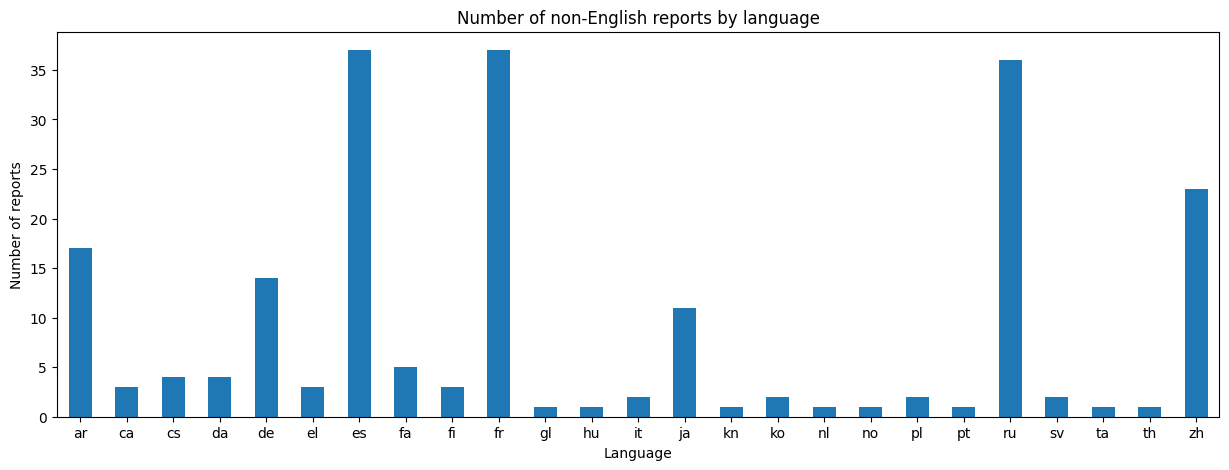

In [15]:
aggs = {
    "languages": {
        "terms": {
            "field": "description.languages",
            "order": {"_key": "asc"},
            "size": 50,
            "exclude": "en"
        }
    }
}

query = DataQuery(search_query = "*:*", source=[], limit=0, aggregations=aggs, coordinates=data_collection)
summary = api.queries.run(query).outputs["data_aggs"]

df = pd.json_normalize(summary["languages"]["buckets"])
df.plot.bar(y="doc_count", x="key", figsize=(15, 5), xlabel="Language", ylabel="Number of reports", rot=0, legend=False, title="Number of non-English reports by language")

### Date histograms

Bucket aggregations can also be used to build date histograms. In this example, we calculate an histogram of the report publication date, by year.

<Axes: title={'center': 'Number of IPCC reports by year'}, xlabel='Publication year', ylabel='Number of reports'>

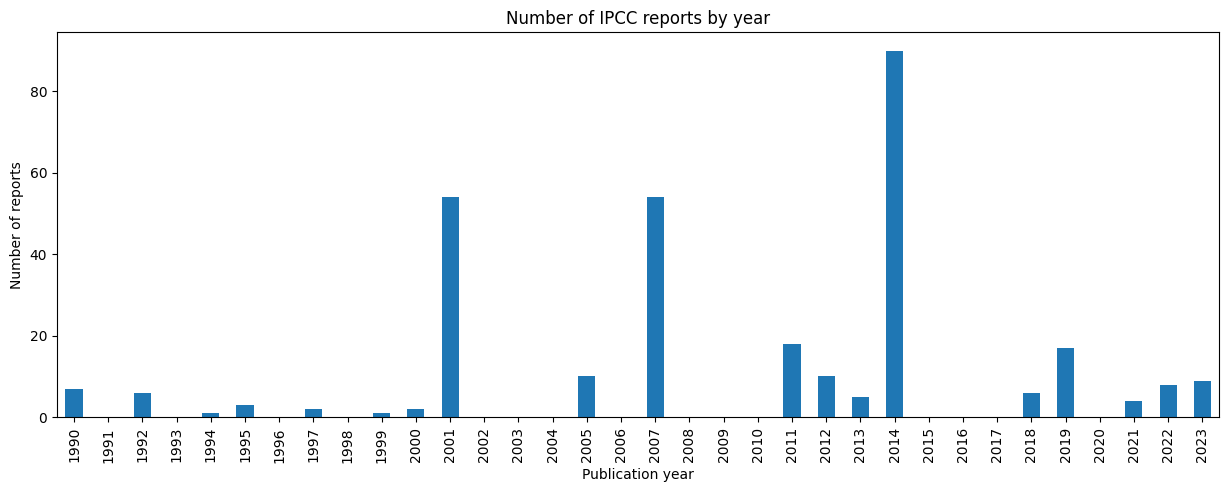

In [16]:
aggs = {
    "by_year": {
        "date_histogram": {
            "field": "description.publication_date",
                "calendar_interval": "year",
                "format": "yyyy",
                "min_doc_count": 0
        }
    }
}

query = DataQuery(search_query = search_query, source=[], limit=0, aggregations=aggs, coordinates=data_collection)
summary = api.queries.run(query).outputs["data_aggs"]

df = pd.json_normalize(summary["by_year"]["buckets"])
df.plot.bar(y="doc_count", x="key_as_string", figsize=(15, 5), xlabel="Publication year", ylabel="Number of reports", legend=False, title="Number of IPCC reports by year")


### Aggregations on arrays

You can also use scripts within aggregations to access more complex metrics from reports.
In this example, we count the number of tables that contain _net-zero emissions_ text in their cells.

In [17]:
search_query = "tables.data.text:\"net-zero emissions\""

aggs = {
    "num_tables": {
        "sum": {
            "script": {
                "source": "doc['tables.#-cols'].length",
                "lang": "painless"
            }
        }
    } 
}

query = DataQuery(search_query = search_query, source=[], limit=0, aggregations=aggs, coordinates=data_collection)
summary = api.queries.run(query).outputs["data_aggs"]

print(f"We found {int(summary['num_tables']['value'])} tables containing 'net-zero emissions'.")

We found 2300 tables containing 'net-zero emissions'.
